In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer

from scipy.stats import skew

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

/Users/jianghanyu/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
len_train = len(df_train)
len_train

1460

In [3]:
len(df_test)

1459

In [4]:
def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [5]:
price = df_train['SalePrice']
price_descend = price.sort_values()
price_descend.head(20)

495     34900
916     35311
968     37900
533     39300
30      40000
710     52000
1337    52500
705     55000
1325    55000
812     55993
1380    58500
410     60000
636     60000
1100    60000
375     61000
462     62383
1432    64500
874     66500
620     67000
398     67000
Name: SalePrice, dtype: int64

In [6]:
price.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [7]:
price_ascend = price.sort_values(ascending=False)
price_ascend.head(20)

691     755000
1182    745000
1169    625000
898     611657
803     582933
1046    556581
440     555000
769     538000
178     501837
798     485000
185     475000
1373    466500
1243    465000
591     451950
527     446261
473     440000
58      438780
349     437154
496     430000
389     426000
Name: SalePrice, dtype: int64

In [8]:
# Delete the rows with price > 600000 or price < 50000
df_train = df_train[df_train['SalePrice'] > 50000]
df_train = df_train[df_train['SalePrice'] < 600000]                    
df_train['SalePrice'].describe()

count      1451.000000
mean     180028.172295
std       74617.962889
min       52000.000000
25%      130000.000000
50%      163000.000000
75%      213750.000000
max      582933.000000
Name: SalePrice, dtype: float64

In [9]:
# Log transform for price
target = df_train[df_train.columns.values[-1]]
target_log = np.log(target)

In [10]:
target_log.describe()

count    1451.000000
mean       12.025320
std         0.383869
min        10.858999
25%        11.775290
50%        12.001505
75%        12.272562
max        13.275828
Name: SalePrice, dtype: float64

In [11]:
# Combine train and test data for categorical feature
df_train = df_train[df_train.columns.values[:-1]]
df = df_train.append(df_test, ignore_index = True)

In [12]:
cats = []
for col in df.columns.values:
    if df[col].dtype == 'object':
        cats.append(col)
df_cont = df.drop(cats, axis=1)
df_cat = df[cats]

In [13]:
for col in df_cont.columns.values:
    if np.sum(df_cont[col].isnull()) > 50:
        df_cont = df_cont.drop(col, axis = 1)
    elif np.sum(df_cont[col].isnull()) > 0:
        median = df_cont[col].median()
        idx = np.where(df_cont[col].isnull())[0]
        df_cont[col].iloc[idx] = median

        outliers = np.where(is_outlier(df_cont[col]))
        max_val = df_cont[col].max()
        df_cont[col].iloc[outliers] = max_val
        
        if skew(df_cont[col]) > 0.75:
            df_cont[col] = np.log(df_cont[col])
            df_cont[col] = df_cont[col].apply(lambda x: 0 if x == -np.inf else x)
        
        df_cont[col] = Normalizer().fit_transform(df_cont[col].reshape(1,-1))[0]

/Users/jianghanyu/.local/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide
/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide
/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykern

In [14]:
for col in df_cat.columns.values:
    if np.sum(df_cat[col].isnull()) > 50:
        df_cat = df_cat.drop(col, axis = 1)
        continue
    elif np.sum(df_cat[col].isnull()) > 0:
        df_cat[col] = df_cat[col].fillna('MIA')
        
    df_cat[col] = LabelEncoder().fit_transform(df_cat[col])
    
    num_cols = df_cat[col].max()
    for i in range(num_cols):
        col_name = col + '_' + str(i)
        df_cat[col_name] = df_cat[col].apply(lambda x: 1 if x == i else 0)
        
    df_cat = df_cat.drop(col, axis = 1)

/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [15]:
df_new = df_cont.join(df_cat)
df_train = df_new.iloc[:len(df_train)]

In [16]:
# How many columns in df_train
print len(df_train.columns), len(df_train)

206 1451


In [17]:
# Check if some categorical values only appears in train data
for col in df_train.columns.values:
    if not np.any(df_train[col]):
        print col
        df_new = df_new.drop(col, axis=1)

MSZoning_2
Utilities_1
Exterior1st_8
Exterior2nd_8
KitchenQual_3
Functional_0
SaleType_6


In [18]:
# How many columns now
len(df_new.columns)

199

In [19]:
# Split train and test set
X_train = df_new.iloc[:len(df_train)]
y_train = target_log

X_test = df_new.iloc[len(df_train):]

In [20]:
np.all(np.isfinite(X_train))

True

In [21]:
np.any(np.isnan(X_train))

False

In [22]:
import xgboost as xgb
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=5,
                 min_child_weight=1.5,
                 n_estimators=3000,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

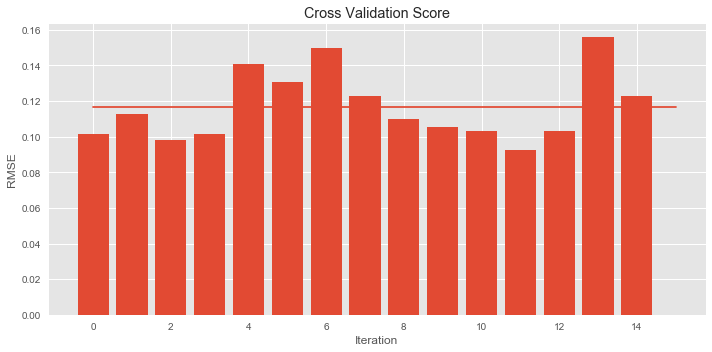

In [25]:
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(mean_squared_error, False)
cv_score = np.sqrt(-cross_val_score(estimator=regr, X=X_train, y=y_train, cv=15, scoring = scorer))

plt.figure(figsize=(10,5))
plt.bar(range(len(cv_score)), cv_score)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')

plt.plot(range(len(cv_score) + 1), [cv_score.mean()] * (len(cv_score) + 1))
plt.tight_layout()

In [26]:
cv_score.mean()

0.1167063615410283

In [27]:
regr.fit(X_train, y_train)
# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(X_test)
y_pred_xgb = np.exp(y_pred_xgb)
# Submission
sub = pd.DataFrame()
sub['Id'] = df_test["Id"]
sub['SalePrice'] = y_pred_xgb
sub.to_csv('submission_outlier_and_xgb.csv',index=False)